In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from statistics import mode
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
# SET50 (unrealize)
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'GLOBAL', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

# remove (low data) : TPIPP WHA SPRC SAWAD PSH MTLS IVL GPSC EA CBG BPP BEAUTY PTTGC

In [244]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('./SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        temp_value = 0
        for row in file_data:
            if row[2] is '':
                continue
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                temp = (float(row[1]) + float(row[4]))/2.0
                if temp_value != 0:
                    unrealize = (temp - temp_value) / temp_value
                else:
                    unrealize = 0
                unrealize = ["{0:.4f}".format(unrealize)]
                stock_data.append(unrealize)
                temp_value = temp
                
    return stock_data

def mean_square_error(actual, predict):
    length = len(actual)
    sums_error = 0.0
    for i, j in zip(actual, predict):
        sums_error += (i - j)**2
    
    return sums_error / length

In [245]:
def findNewXTest(x_test, predict):
    for (index, element) in enumerate(x_test[0]):
        for i in range(len(element)):
            if i == 0:
                continue
            elif i < 29:
                element[i - 1] = element[i]
            else:
                element[i - 1] = element[i]
                element[i] = predict[index]
    return x_test

In [246]:
stock_datas = [ load_stock_data(x, 2007, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

for index, element in enumerate(stock_datas):
    if len(element) < min_count:
        min_count = len(element)

min_count

2043

In [247]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(len(stock_datas), 30, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(32, (3 ,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())  
    model.add(Dense(512))  
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(len(stock_datas)))
    model.add(Activation('softmax'))
    
    return model

In [248]:
lr = 0.1
decay = 1e-5

In [249]:
model_sgd = create_model()

optimizer = SGD(lr=lr, decay=decay)

model_sgd.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

In [250]:
model_adam = create_model()

optimizer = Adam(lr=lr, decay=decay)

model_adam.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

In [251]:
rounds = min_count - 30
train_index = int(rounds * 0.8)
validate_index = train_index + int(rounds * 0.1)

In [252]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_validate = x[train_index: validate_index].astype('float32')
x_test = x[validate_index: validate_index + 1].astype('float32')

print(x_train.shape, x_validate.shape, x_test.shape)

(1610, 37, 30, 1) (201, 37, 30, 1) (1, 37, 30, 1)


In [ ]:
target = []
index = 0
while index < rounds:
    temp = [stock_datas[i][index + 30][0] for i in range(len(stock_datas))]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_validate = y[train_index: validate_index].astype('float32')
y_test = y[validate_index: rounds].astype('float32')

print(y_train.shape, y_validate.shape, y_test.shape)

(1610, 37) (201, 37) (202, 37)


In [ ]:
epochs = 100

model_sgd.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, shuffle = True, batch_size = 30, verbose= 1)

Train on 1610 samples, validate on 201 samples
Epoch 1/100
1610/1610 [==============================] - 2s 1ms/step - loss: 0.0015 - acc: 0.0242 - val_loss: 9.0906e-04 - val_acc: 0.0199
Epoch 2/100
1610/1610 [==============================] - 1s 491us/step - loss: 0.0015 - acc: 0.0267 - val_loss: 9.0906e-04 - val_acc: 0.0199
Epoch 3/100
1610/1610 [==============================] - 1s 489us/step - loss: 0.0015 - acc: 0.0261 - val_loss: 9.0906e-04 - val_acc: 0.0199
Epoch 4/100
1610/1610 [==============================] - 1s 475us/step - loss: 0.0015 - acc: 0.0292 - val_loss: 9.0906e-04 - val_acc: 0.0199
Epoch 5/100
1610/1610 [==============================] - 1s 496us/step - loss: 0.0015 - acc: 0.0248 - val_loss: 9.0906e-04 - val_acc: 0.0199
Epoch 6/100
1610/1610 [==============================] - 1s 488us/step - loss: 0.0015 - acc: 0.0224 - val_loss: 9.0906e-04 - val_acc: 0.0199
Epoch 7/100
1610/1610 [==============================] - 1s 496us/step - loss: 0.0015 - acc: 0.0242 - val_los

In [227]:
model_adam.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, shuffle = True, batch_size = 30, verbose= 1)

Train on 1711 samples, validate on 201 samples
Epoch 1/100
1711/1711 [==============================] - 2s 1ms/step - loss: 0.0016 - acc: 0.0298 - val_loss: 8.9017e-04 - val_acc: 0.0149
Epoch 2/100
1711/1711 [==============================] - 1s 517us/step - loss: 0.0015 - acc: 0.0310 - val_loss: 8.8496e-04 - val_acc: 0.0498
Epoch 3/100
1711/1711 [==============================] - 1s 513us/step - loss: 0.0015 - acc: 0.0380 - val_loss: 8.7859e-04 - val_acc: 0.0100
Epoch 4/100
1711/1711 [==============================] - 1s 508us/step - loss: 0.0015 - acc: 0.0497 - val_loss: 8.7900e-04 - val_acc: 0.0050
Epoch 5/100
1711/1711 [==============================] - 1s 509us/step - loss: 0.0015 - acc: 0.0339 - val_loss: 8.7937e-04 - val_acc: 0.0100
Epoch 6/100
1711/1711 [==============================] - 1s 517us/step - loss: 0.0015 - acc: 0.0368 - val_loss: 8.7965e-04 - val_acc: 0.0398
Epoch 7/100
1711/1711 [==============================] - 1s 524us/step - loss: 0.0015 - acc: 0.0392 - val_los

1711/1711 [==============================] - 1s 522us/step - loss: 0.0015 - acc: 0.0468 - val_loss: 8.8112e-04 - val_acc: 0.0149
Epoch 59/100
1711/1711 [==============================] - 1s 512us/step - loss: 0.0015 - acc: 0.0514 - val_loss: 8.7895e-04 - val_acc: 0.0149
Epoch 60/100
1711/1711 [==============================] - 1s 515us/step - loss: 0.0015 - acc: 0.0357 - val_loss: 8.7686e-04 - val_acc: 0.0050
Epoch 61/100
1711/1711 [==============================] - 1s 518us/step - loss: 0.0015 - acc: 0.0392 - val_loss: 8.8506e-04 - val_acc: 0.0149
Epoch 62/100
1711/1711 [==============================] - 1s 516us/step - loss: 0.0015 - acc: 0.0351 - val_loss: 8.7706e-04 - val_acc: 0.0149
Epoch 63/100
1711/1711 [==============================] - 1s 523us/step - loss: 0.0015 - acc: 0.0397 - val_loss: 8.8238e-04 - val_acc: 0.0149
Epoch 64/100
1711/1711 [==============================] - 1s 518us/step - loss: 0.0015 - acc: 0.0473 - val_loss: 8.8465e-04 - val_acc: 0.0149
Epoch 65/100
1711/1

In [228]:
test_sgd = x_test.copy()
test_adam = x_test.copy()

In [229]:
error_sgd = []
predict_sgd = []
for (index, element) in enumerate(y_test):
    predict = model_sgd.predict(test_sgd, verbose = 0)
    predict_sgd.append(predict[0])
    error_sgd.append(mean_square_error(element, predict[0]))
    test_sgd = findNewXTest(test_sgd, predict[0])

In [230]:
error_adam = []
predict_adam = []
for (index, element) in enumerate(y_test):
    predict = model_adam.predict(test_adam, verbose = 0)
    predict_adam.append(predict[0])
    error_adam.append(mean_square_error(element, predict[0]))
    test_adam = findNewXTest(test_adam, predict[0])

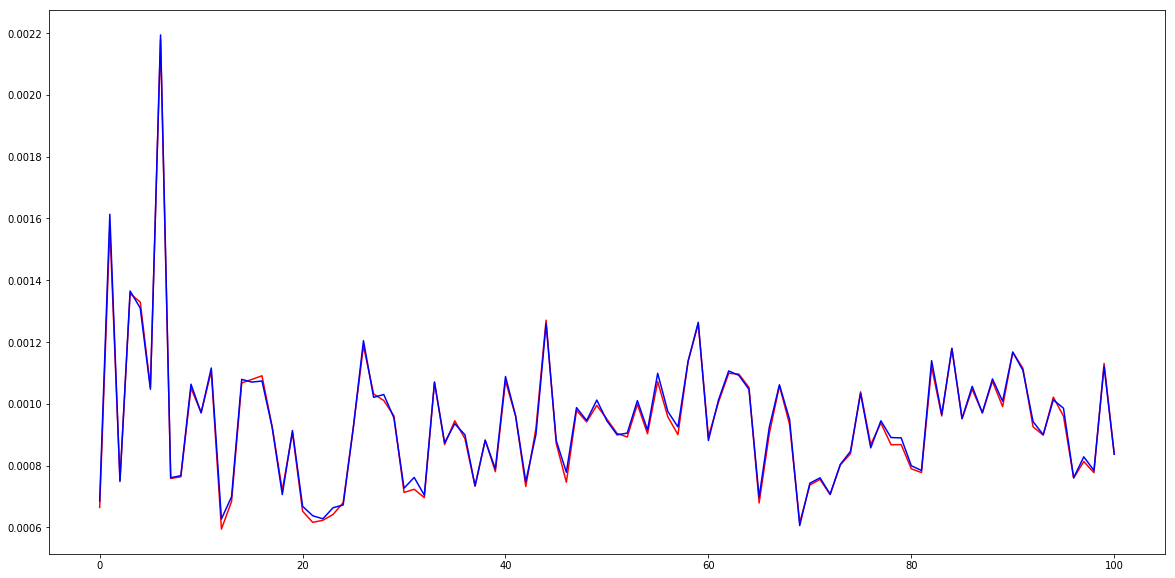

In [231]:
plt.figure(figsize=(20,10))
plt.plot(error_sgd, 'r')
plt.plot(error_adam, 'b')

plt.show()

In [232]:
predict_sgd = np.asarray(predict_sgd).astype('float32')
predict_adam = np.asarray(predict_adam).astype('float32')

In [233]:
def plot_graph(array1, array2):
    plt.figure(figsize=(20,10))
    x_axis = [i for i in range(len(array1))]
    plt.plot(x_axis, array1, 'r')
    plt.plot(x_axis, array2, 'b')

    plt.show()
    
def get_data_from_nparray(nparray, index):
    return_data = [i[index] for i in nparray]
    return return_data

ADVANC


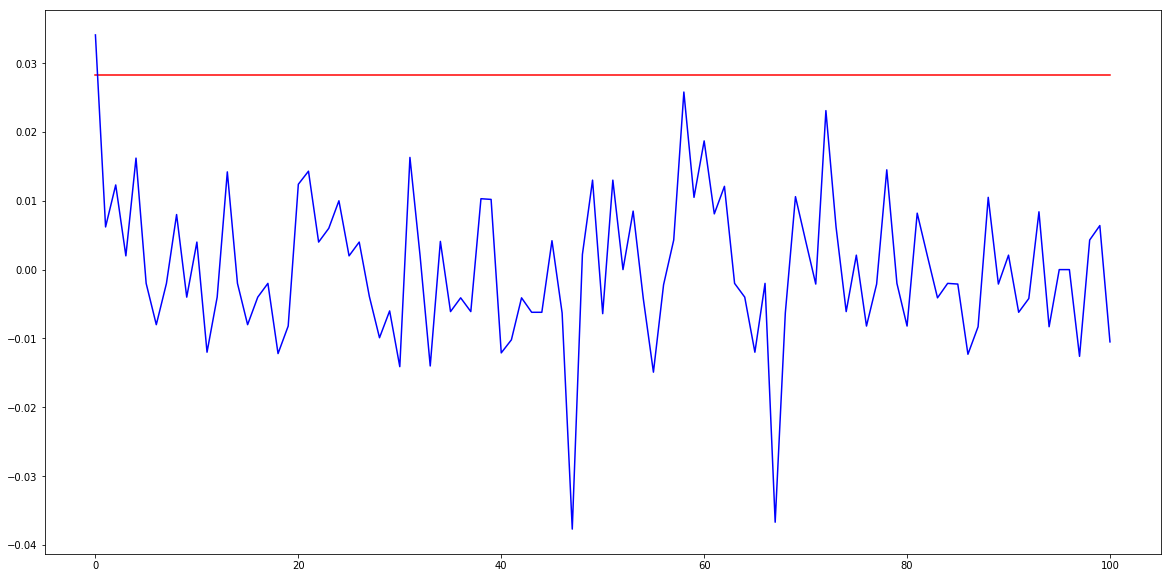

AOT


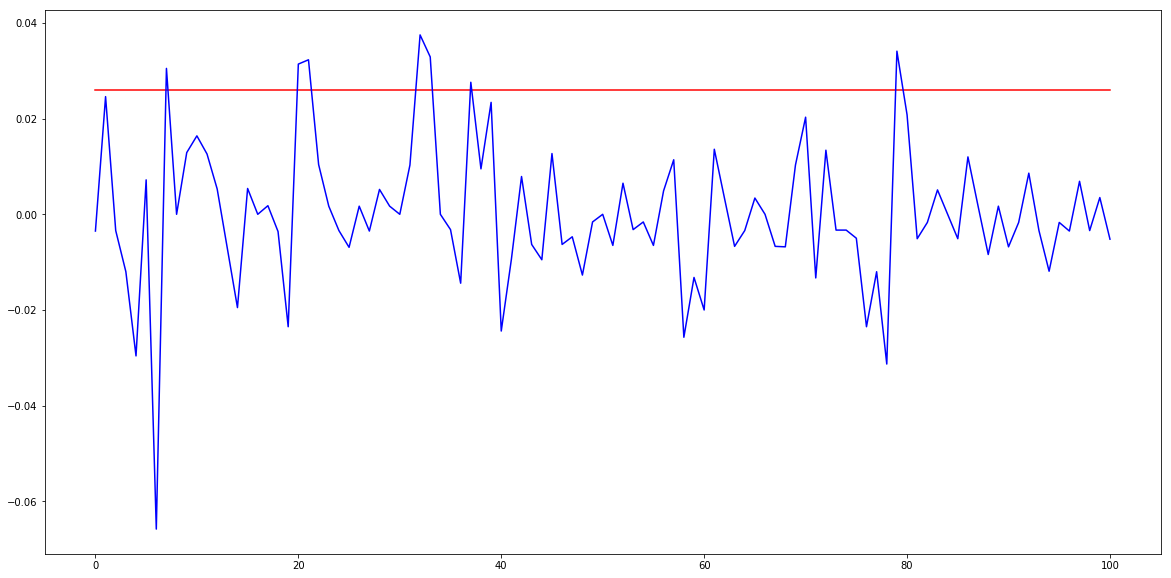

BANPU


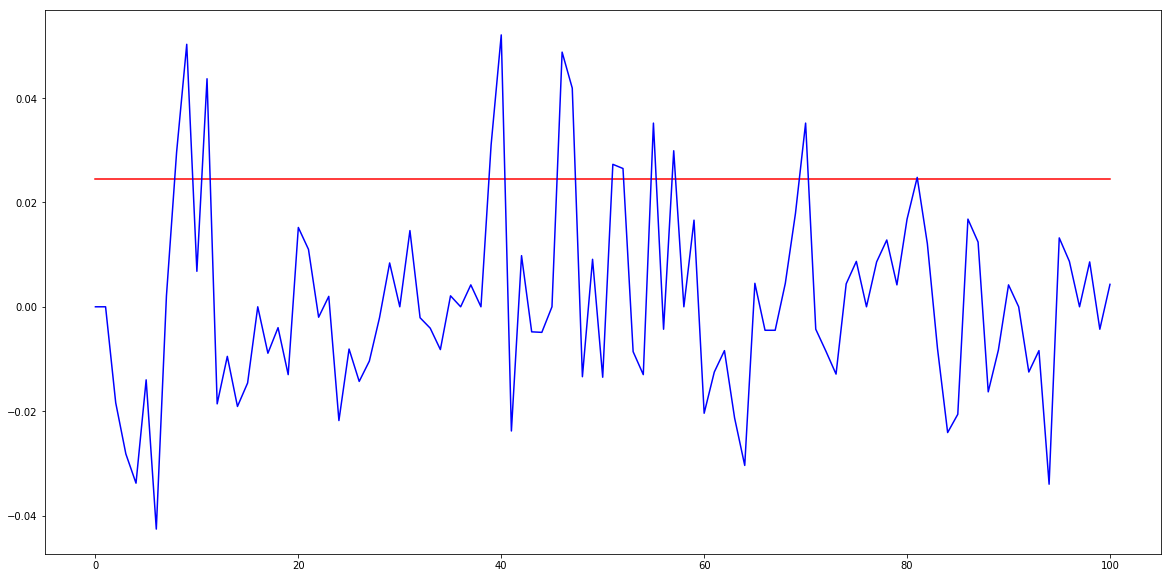

BBL


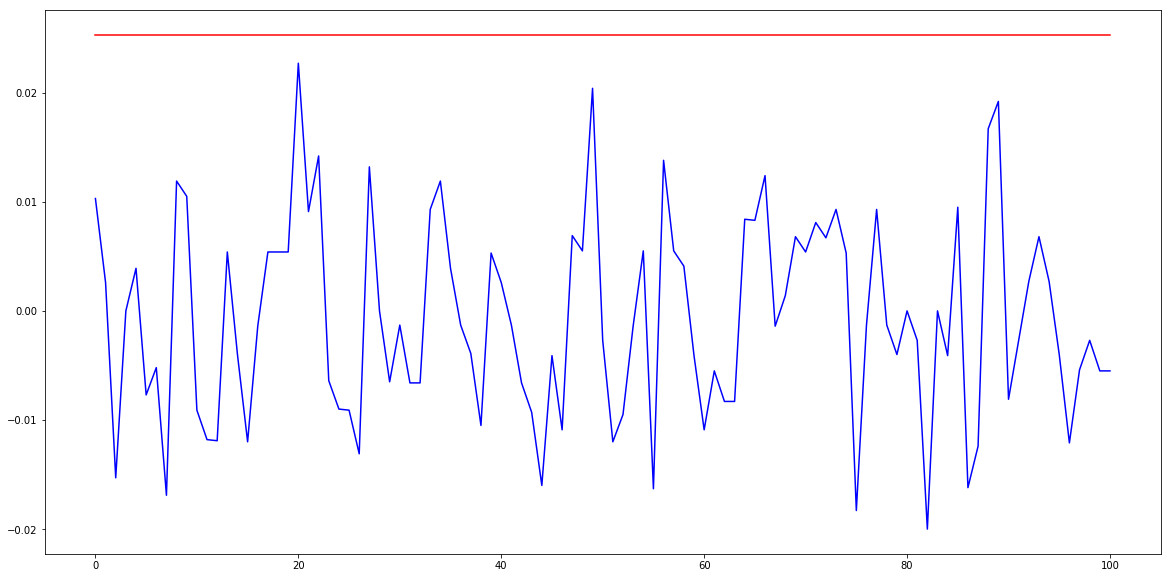

BCP


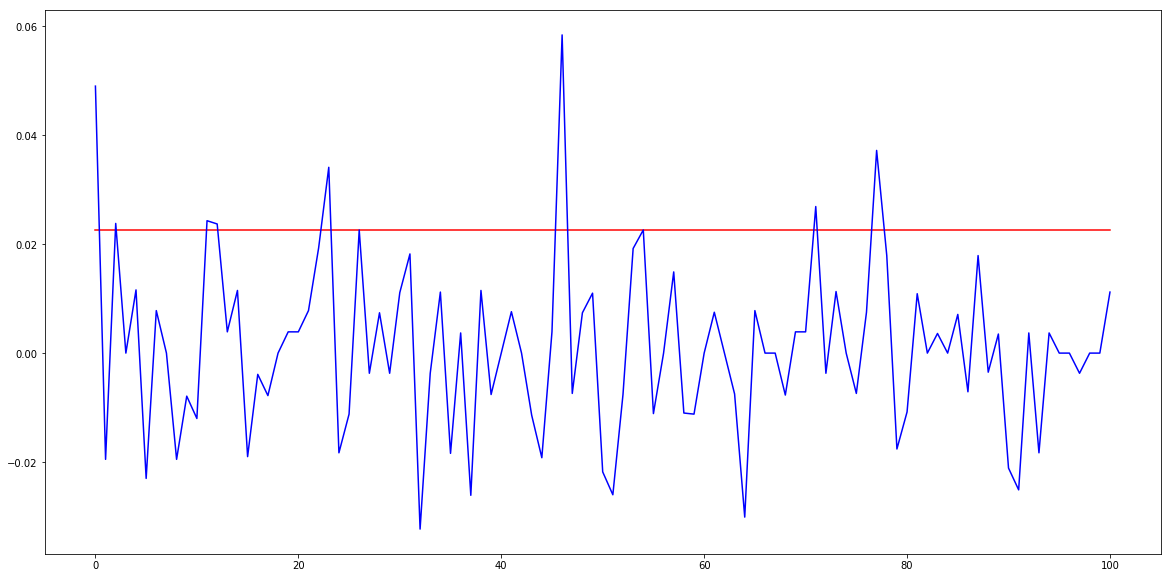

BDMS


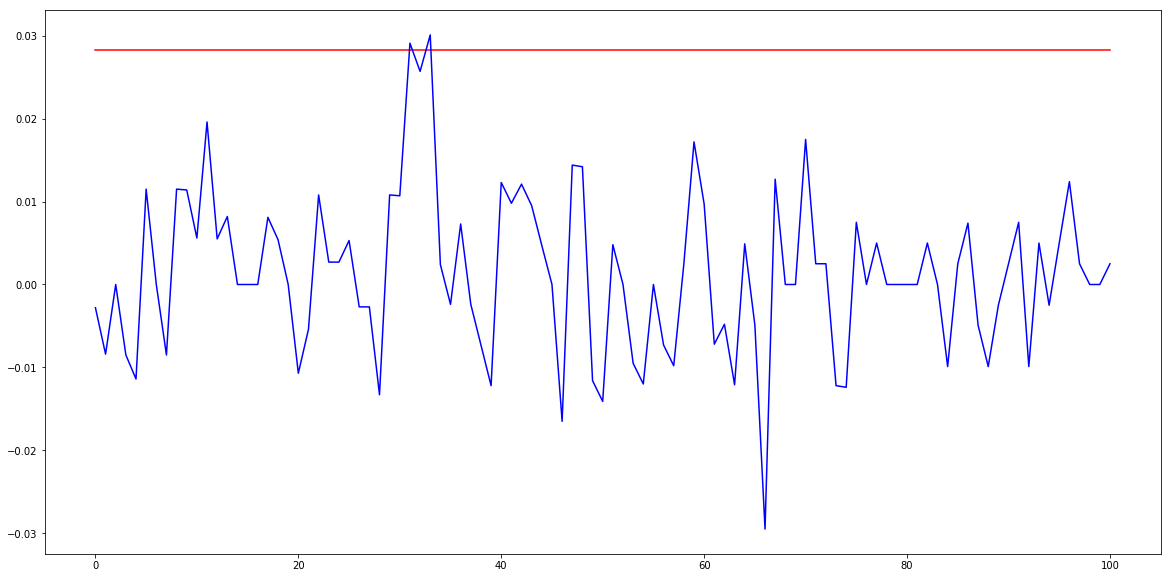

BEM


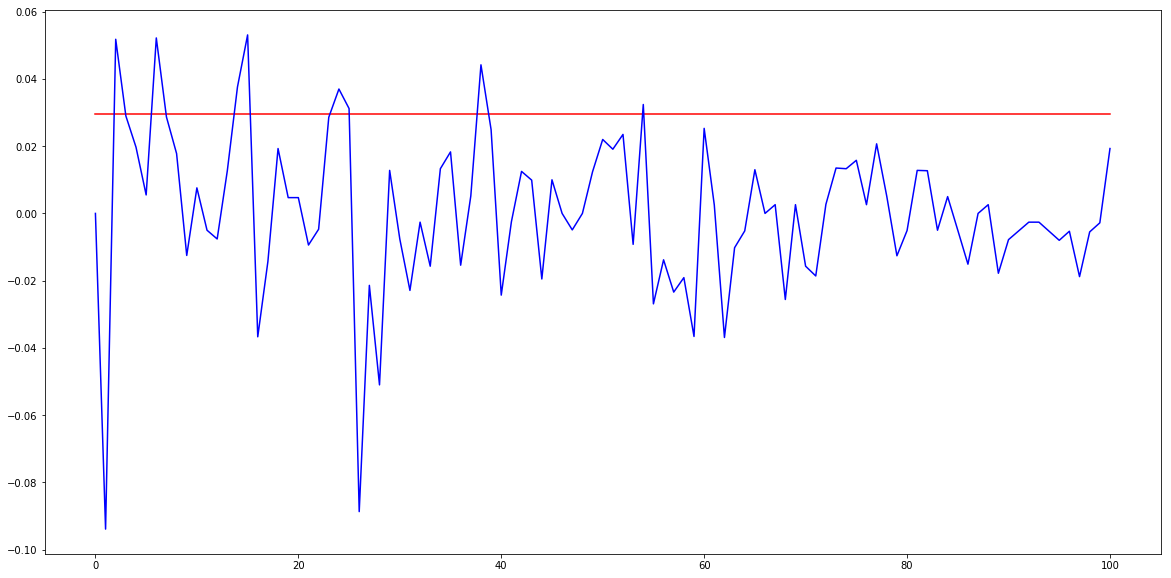

BH


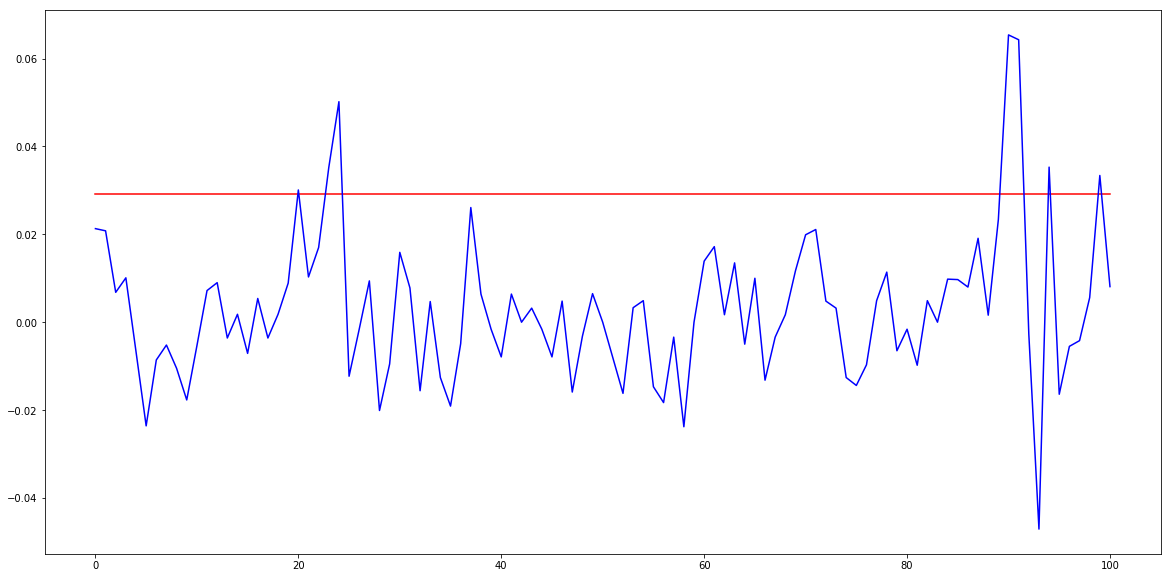

BJC


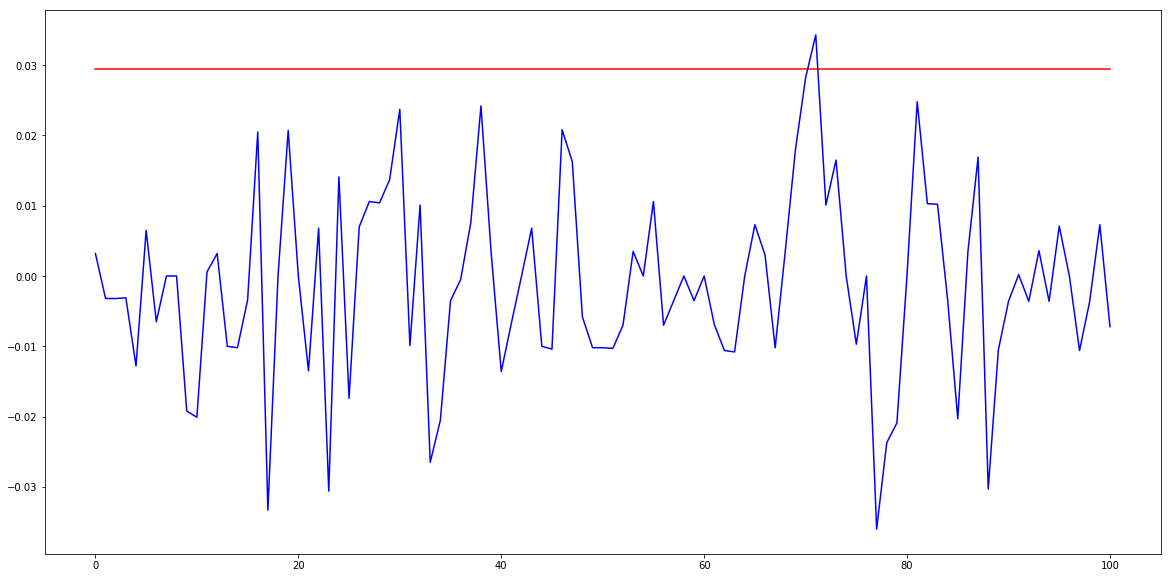

BTS


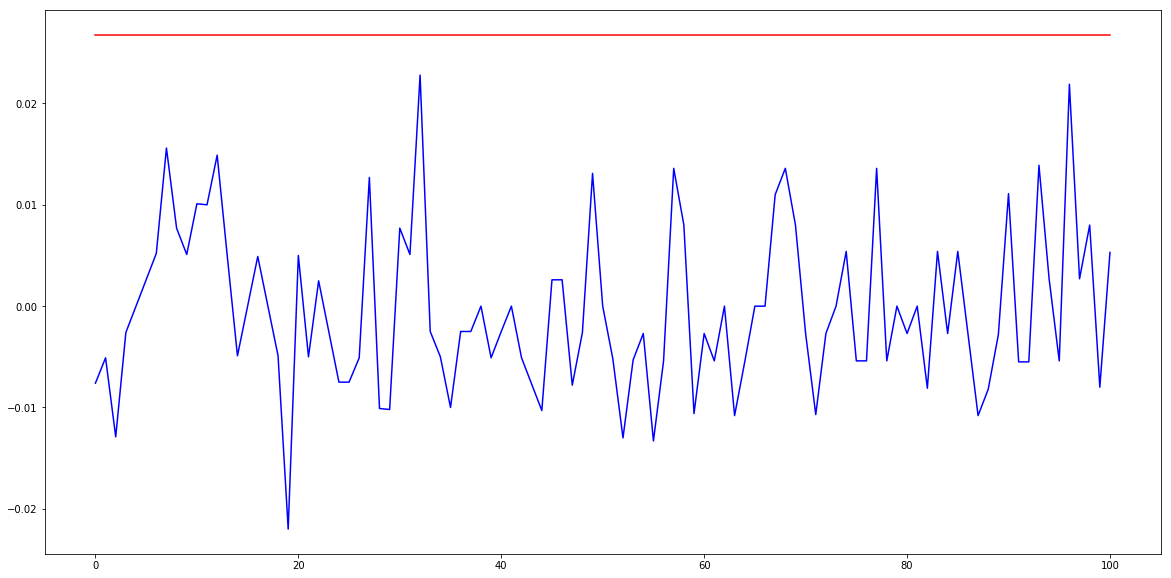

CENTEL


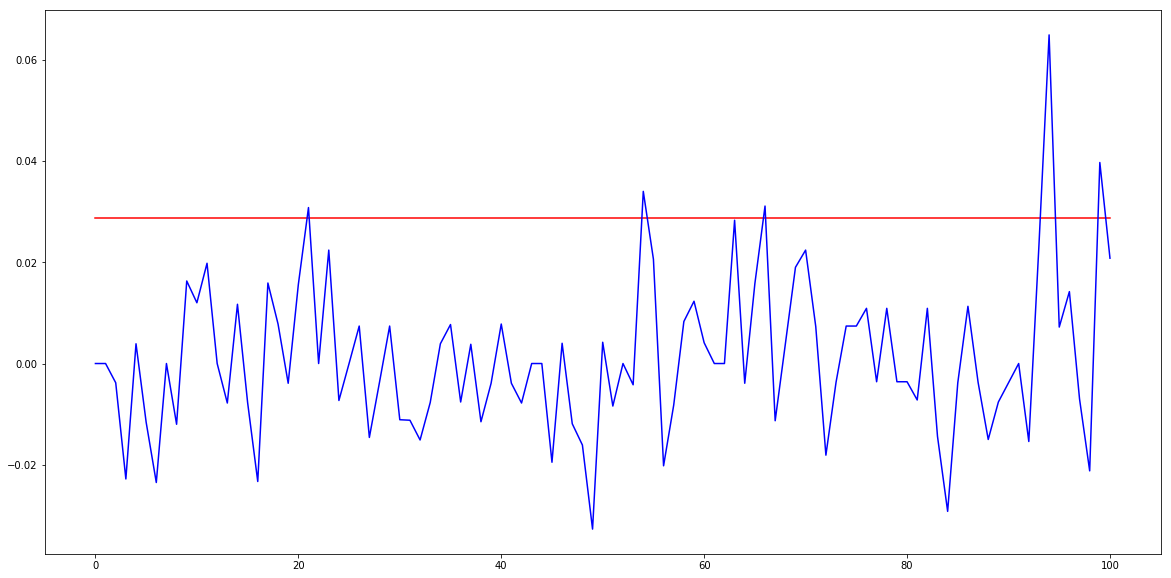

CPALL


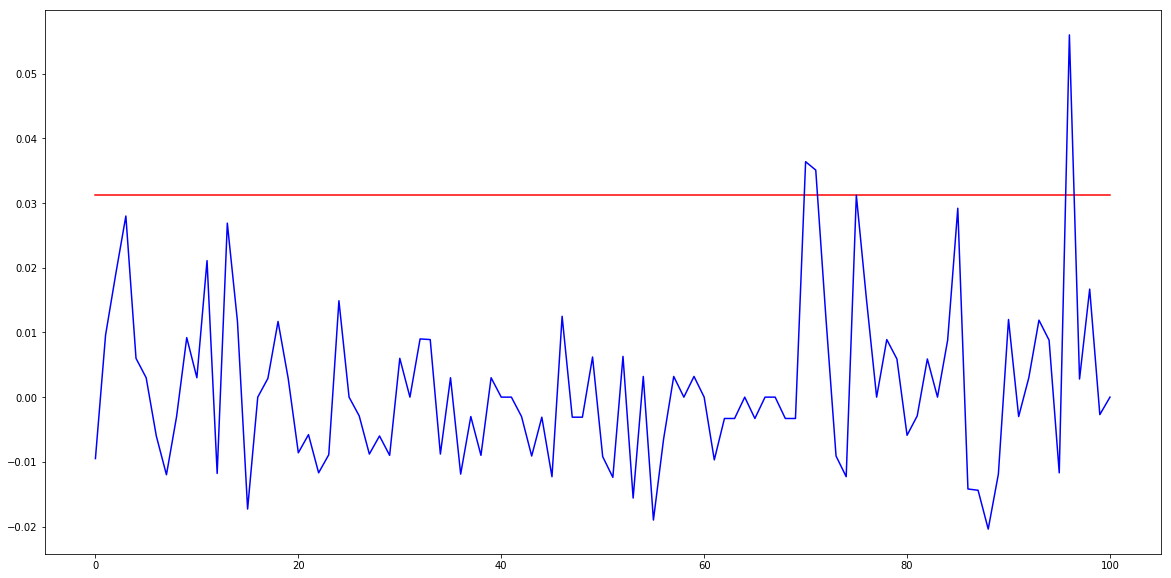

CPF


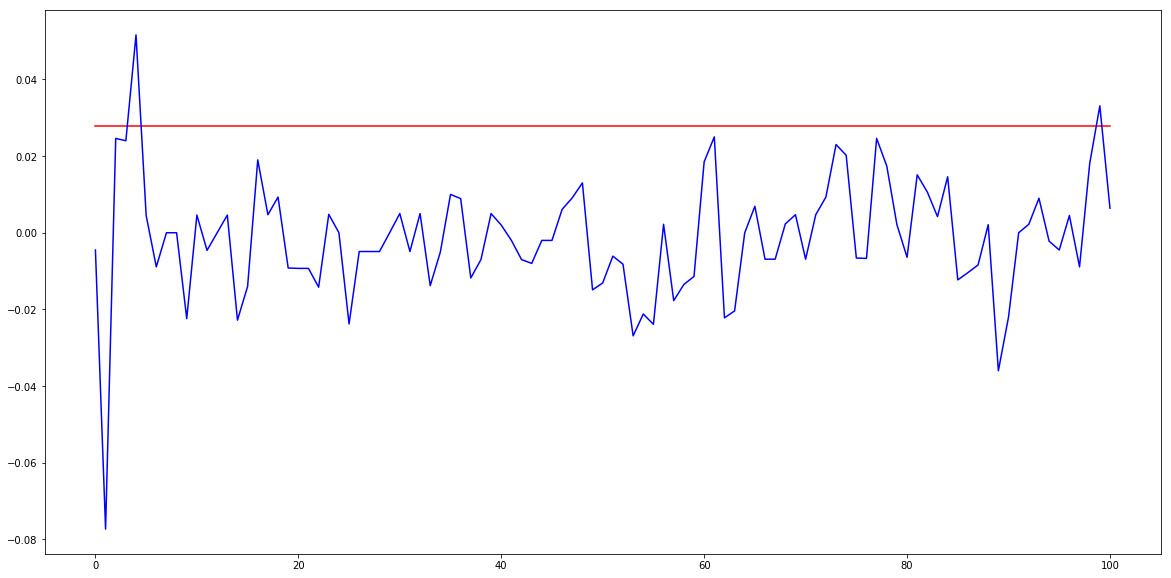

CPN


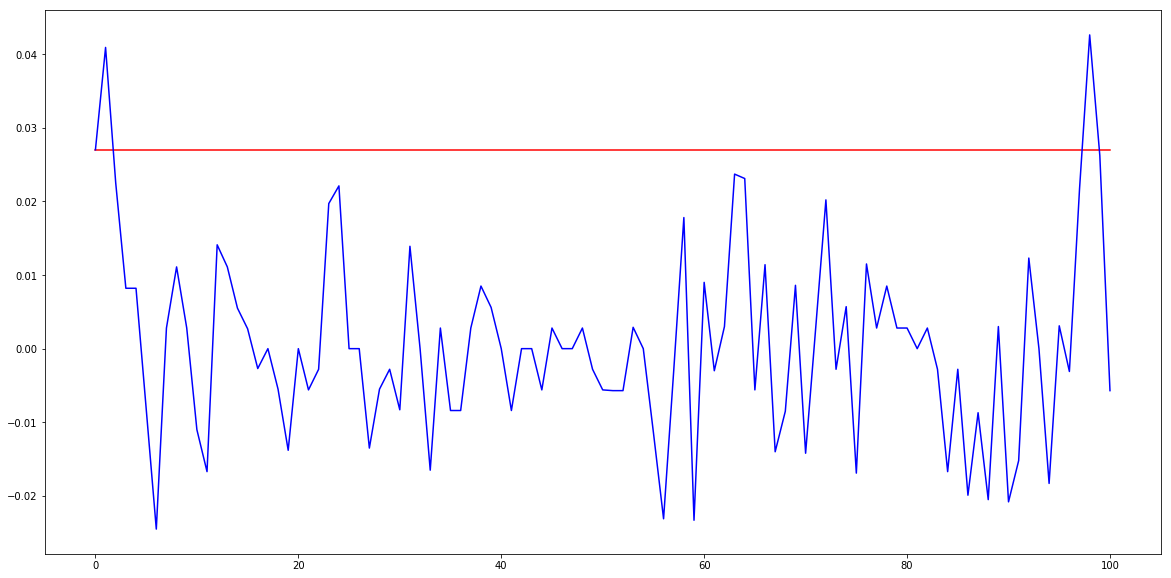

DTAC


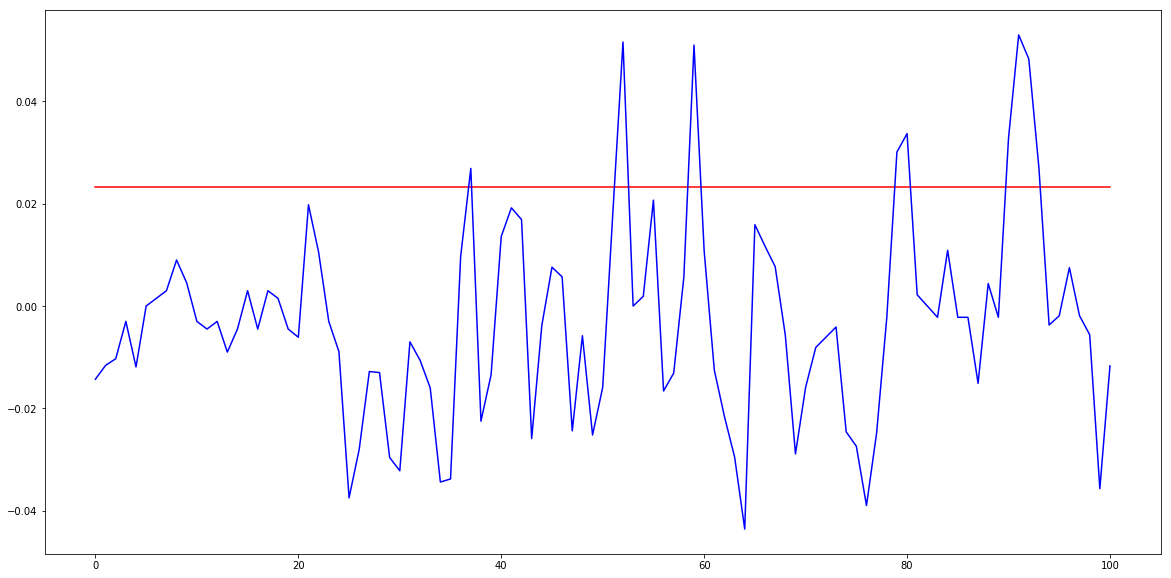

EGCO


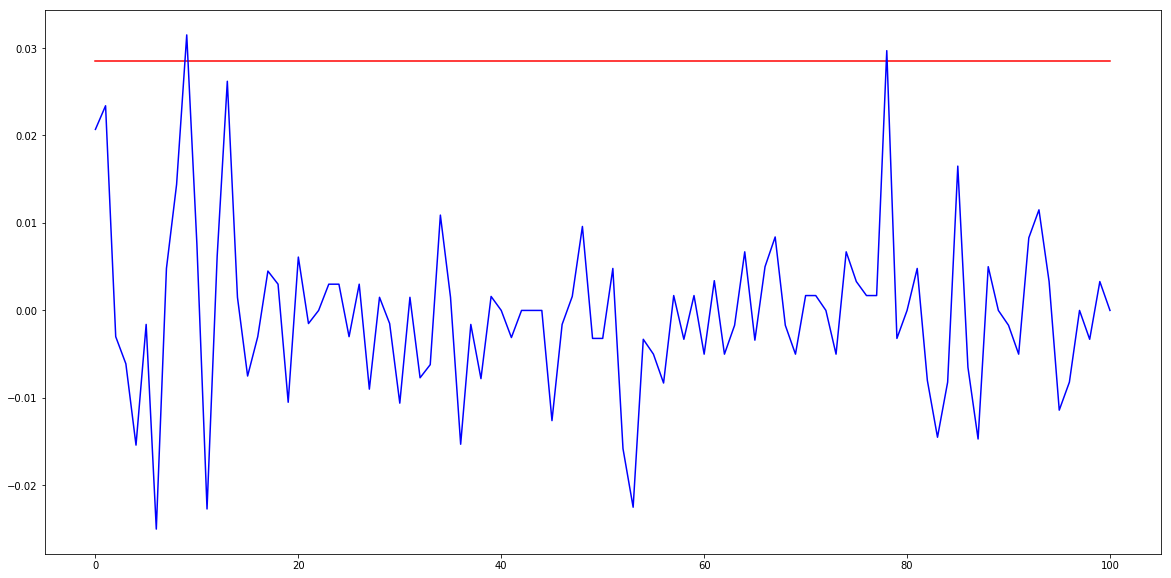

GLOBAL


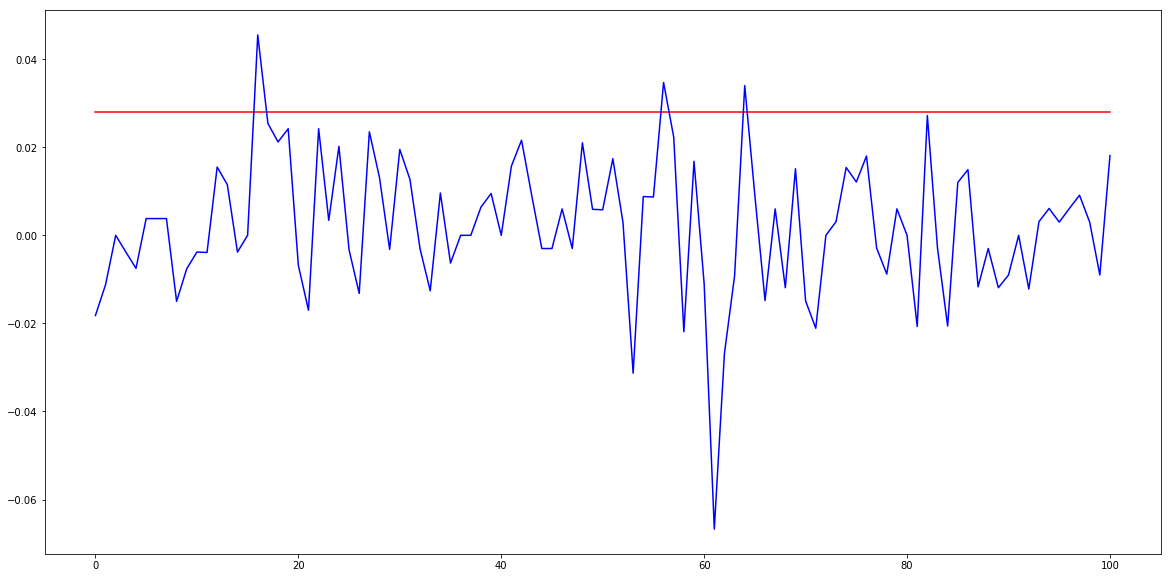

HMPRO


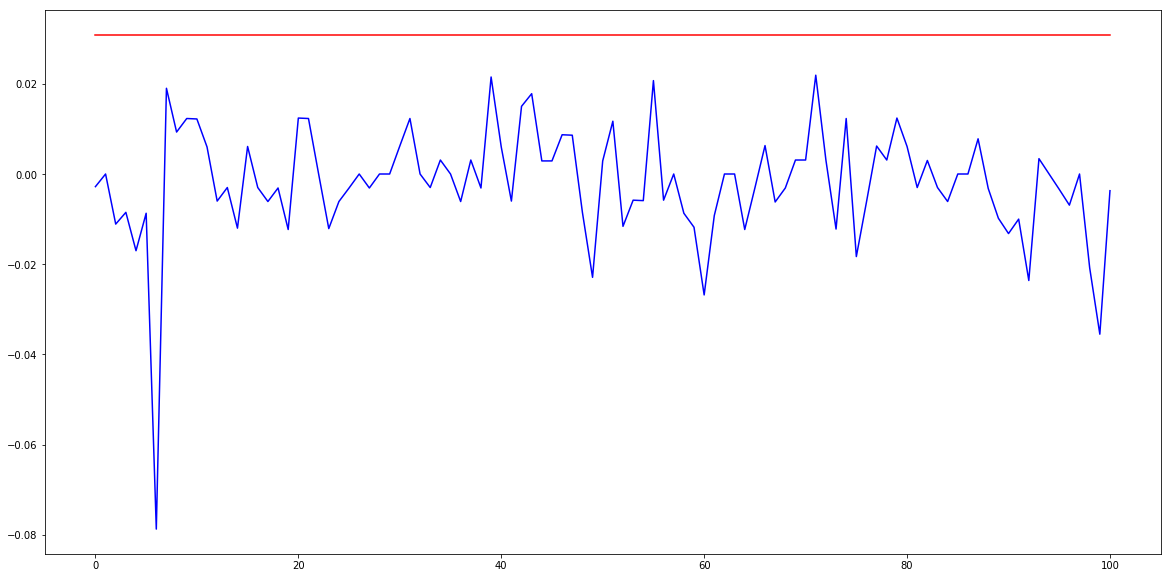

INTUCH


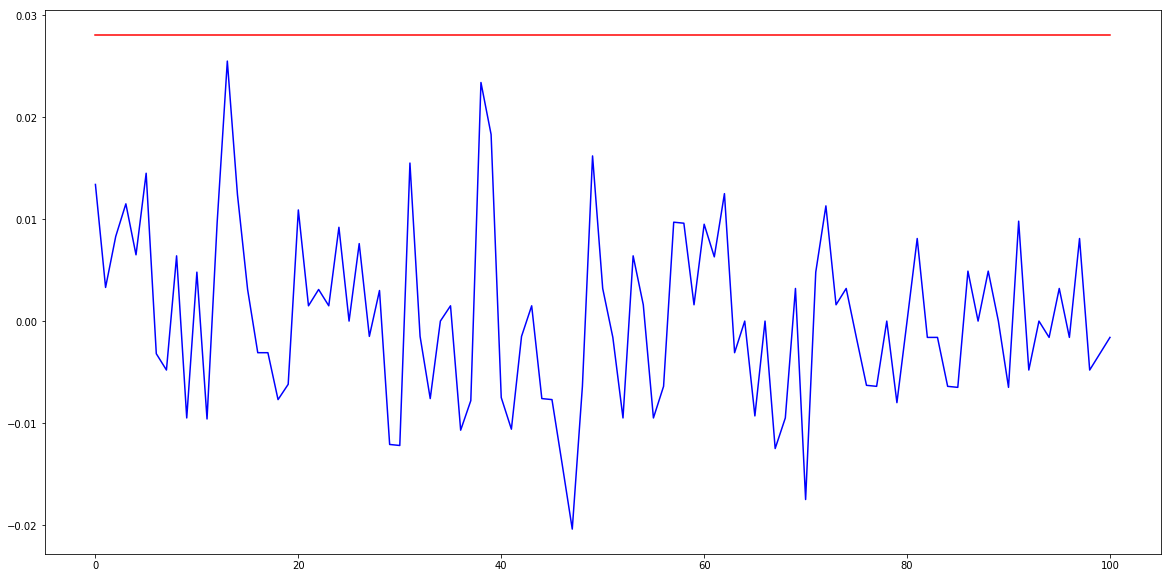

IRPC


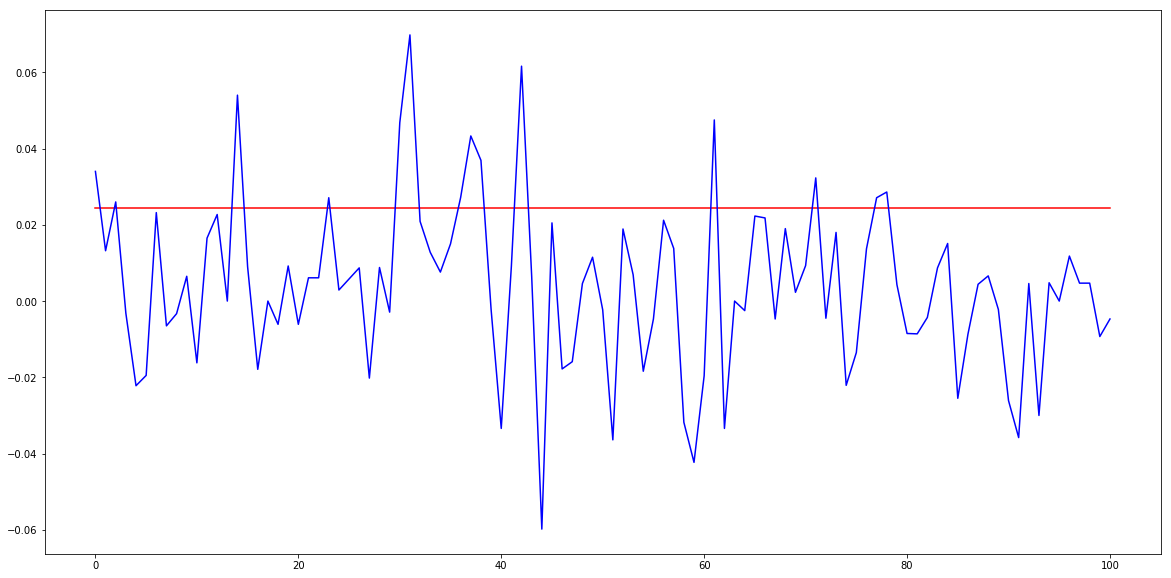

KBANK


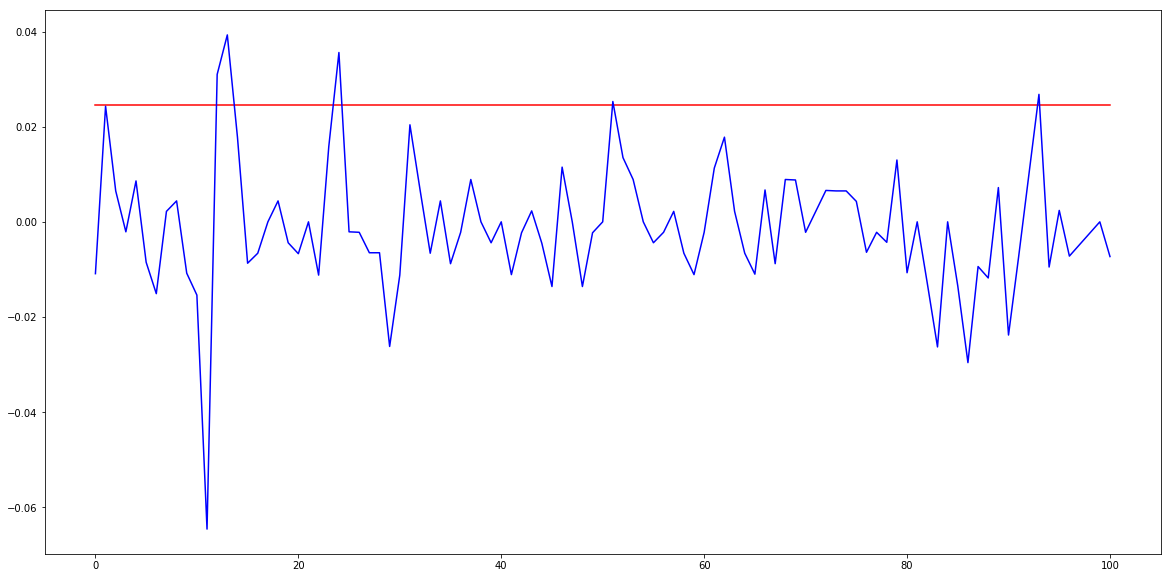

KCE


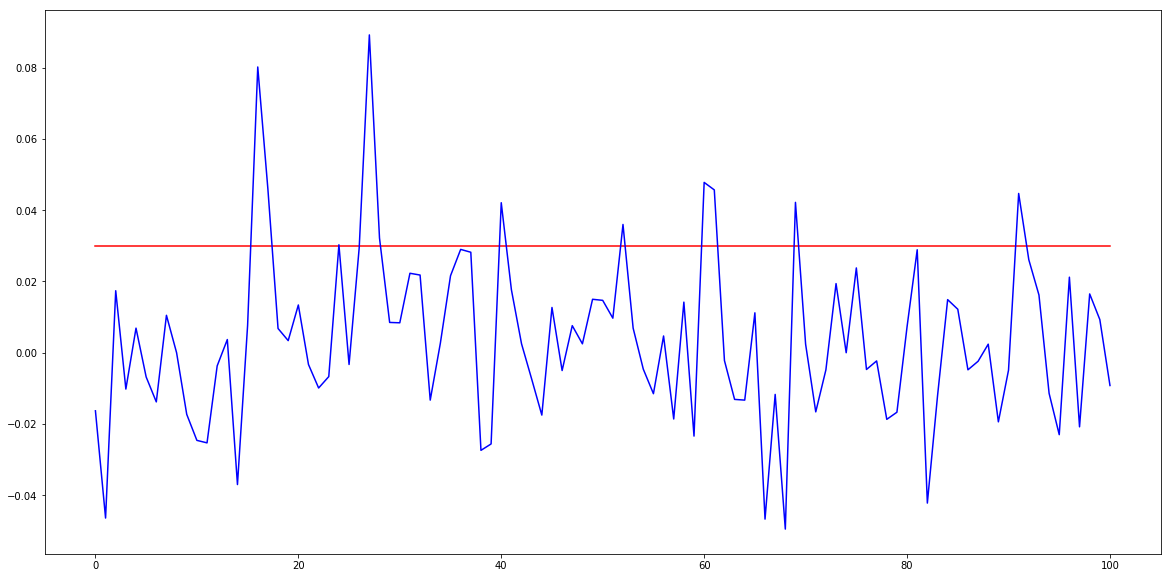

KKP


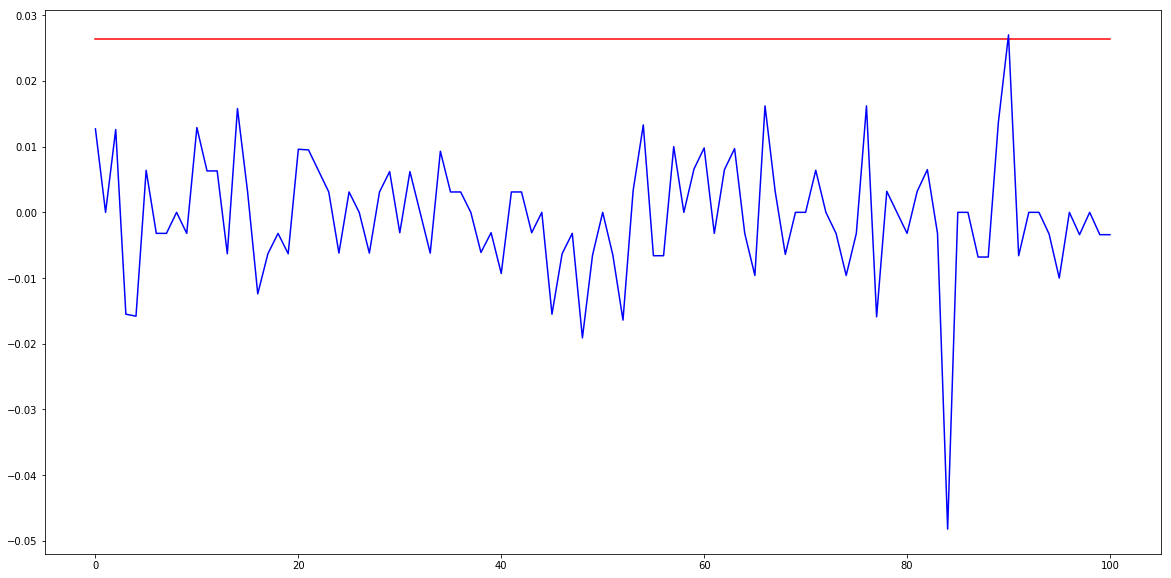

KTB


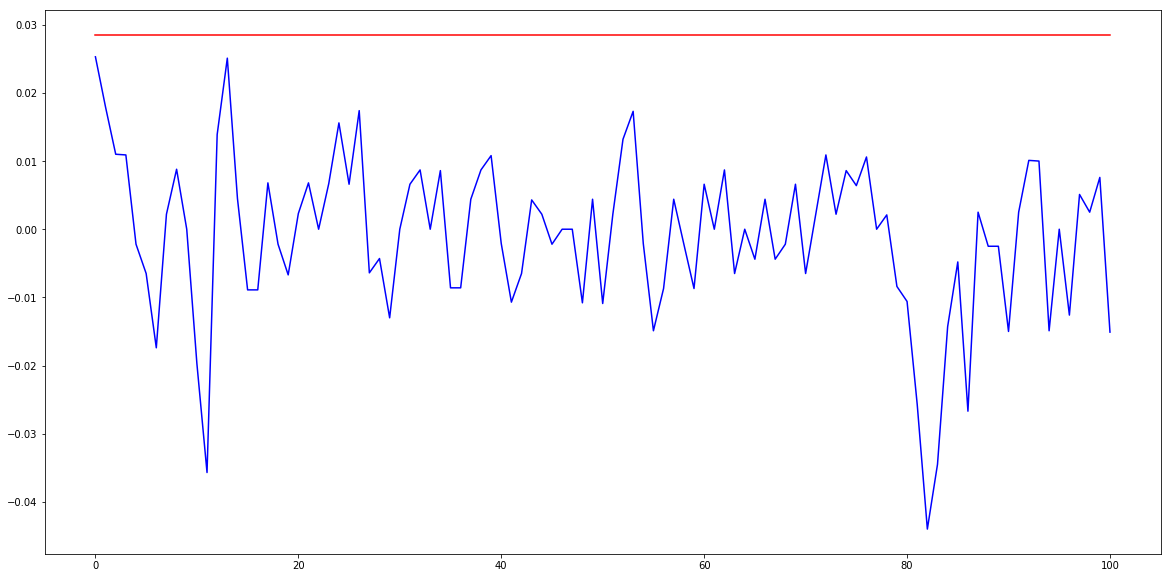

LH


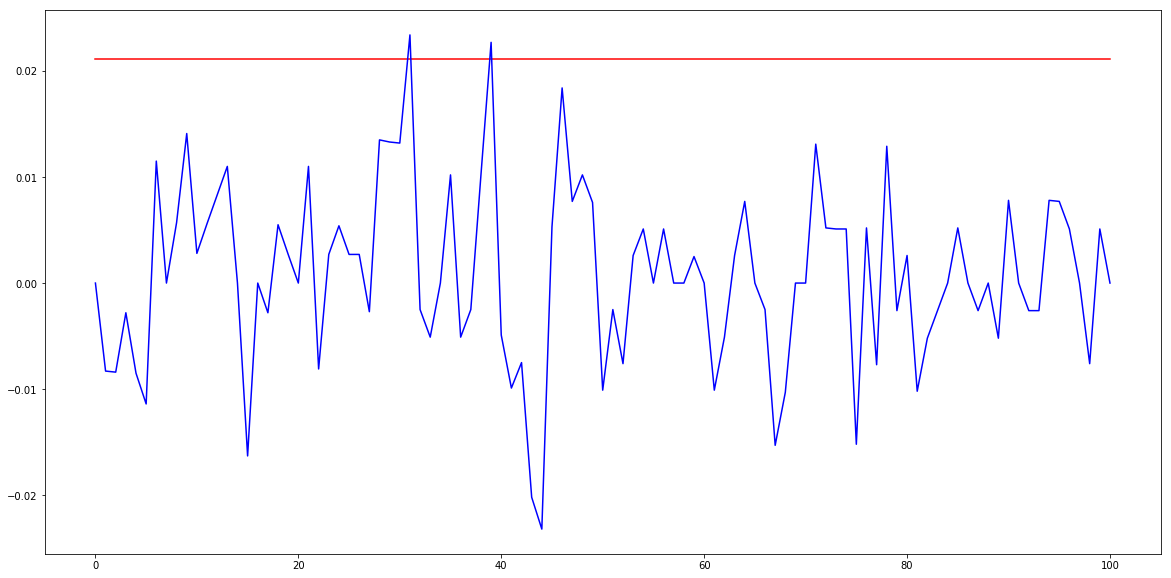

MINT


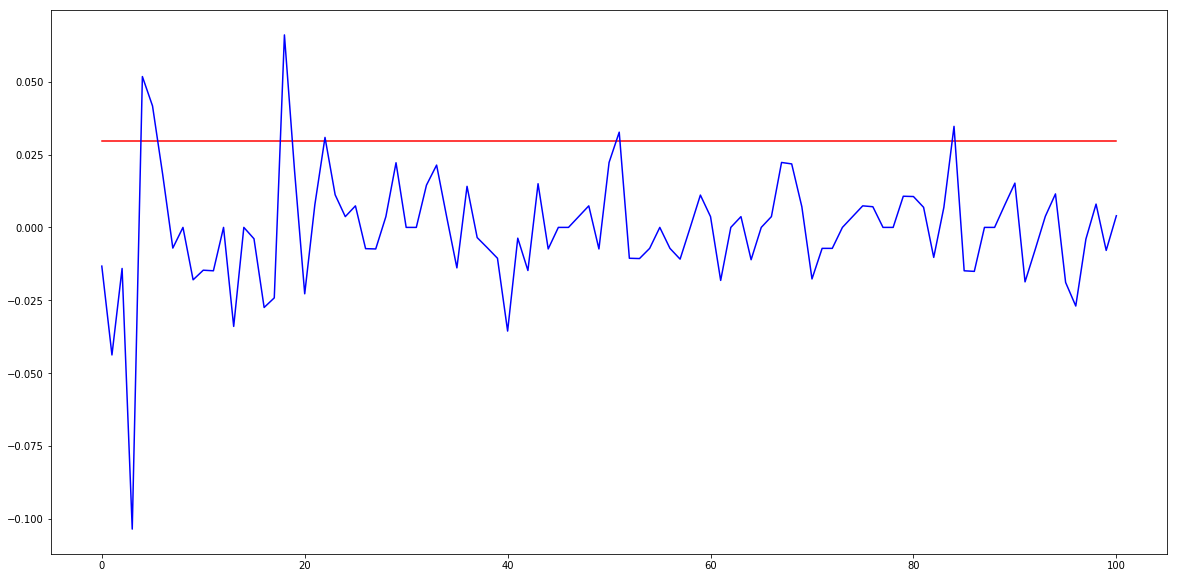

PTT


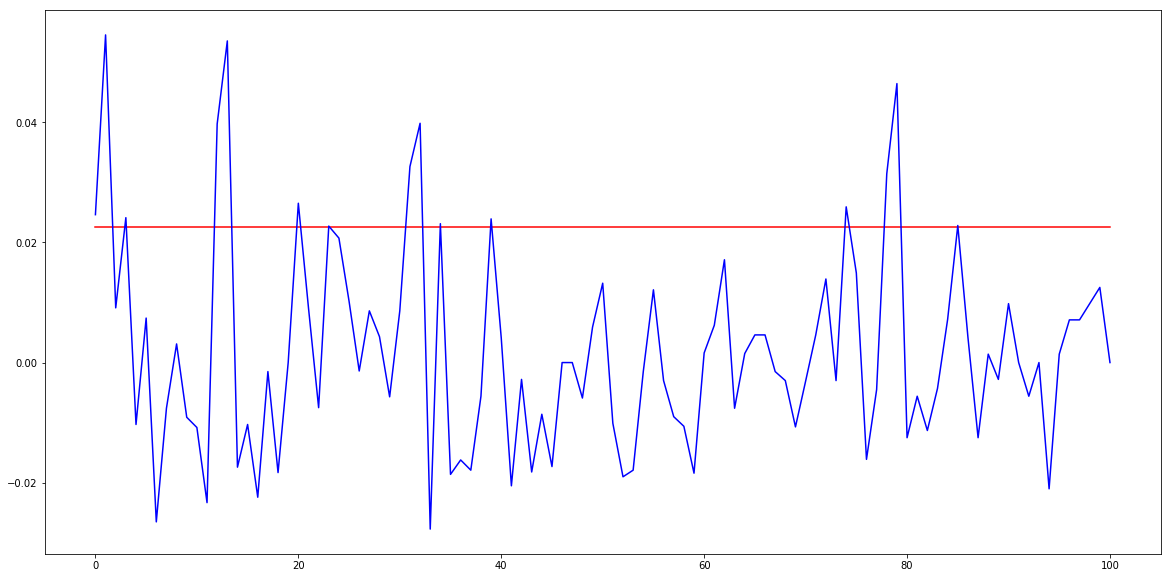

PTTEP


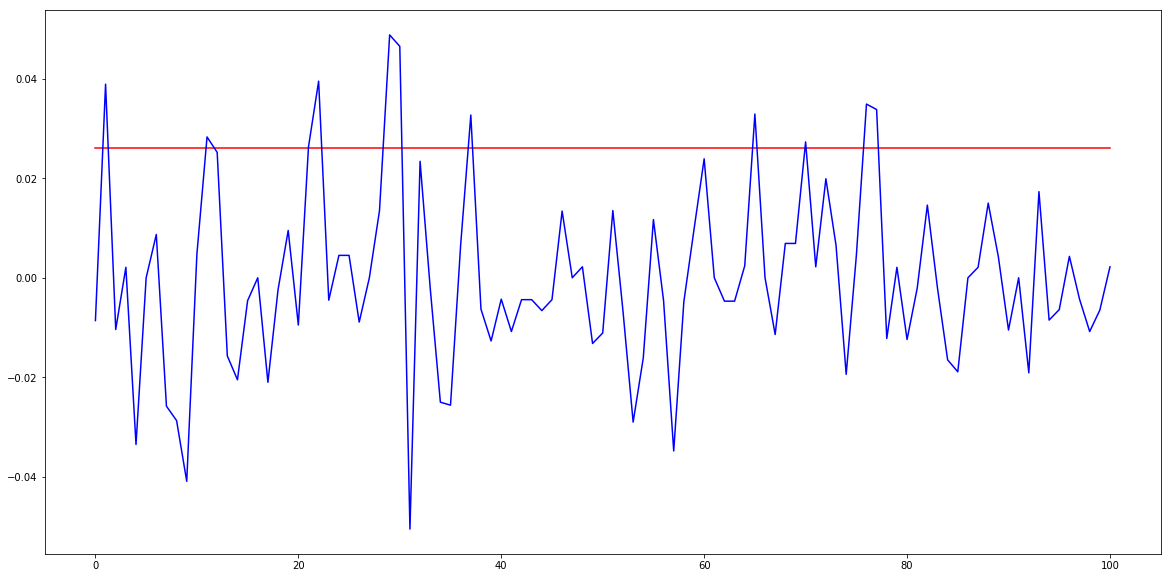

ROBINS


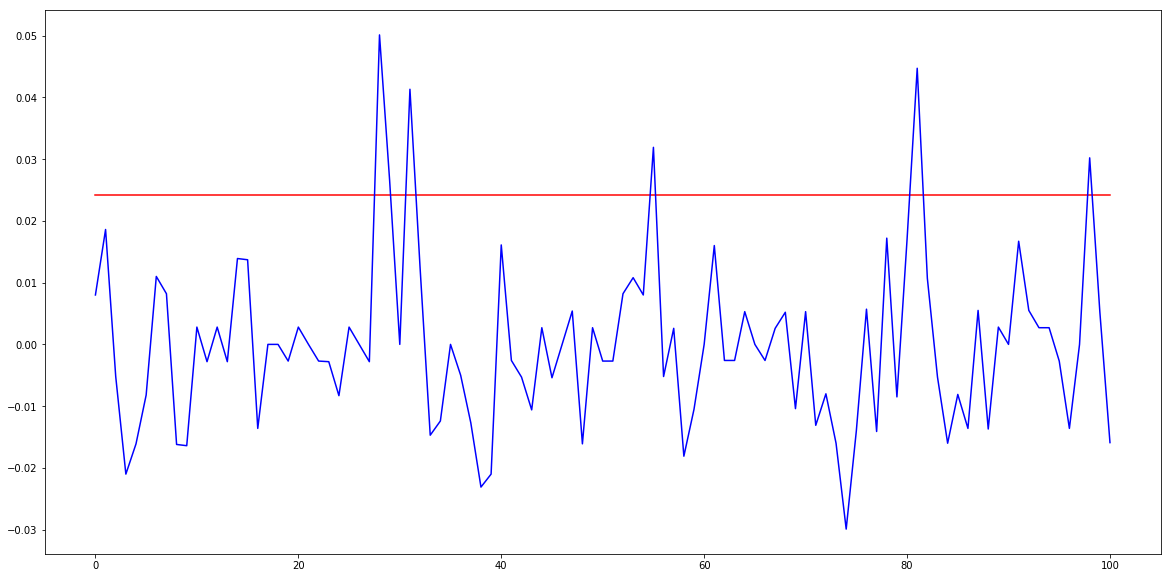

SCB


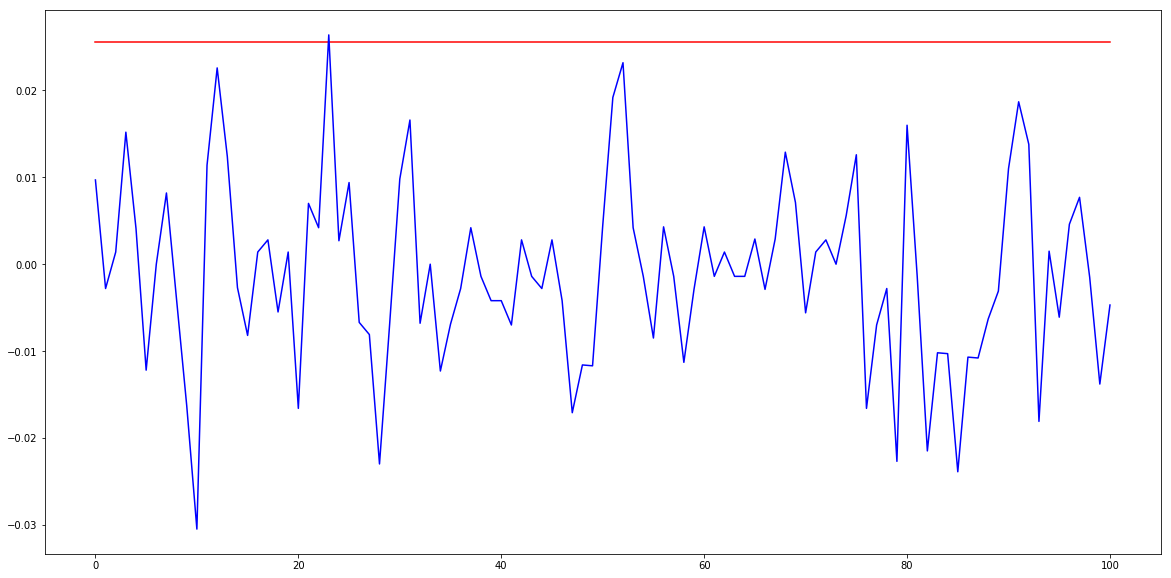

SCC


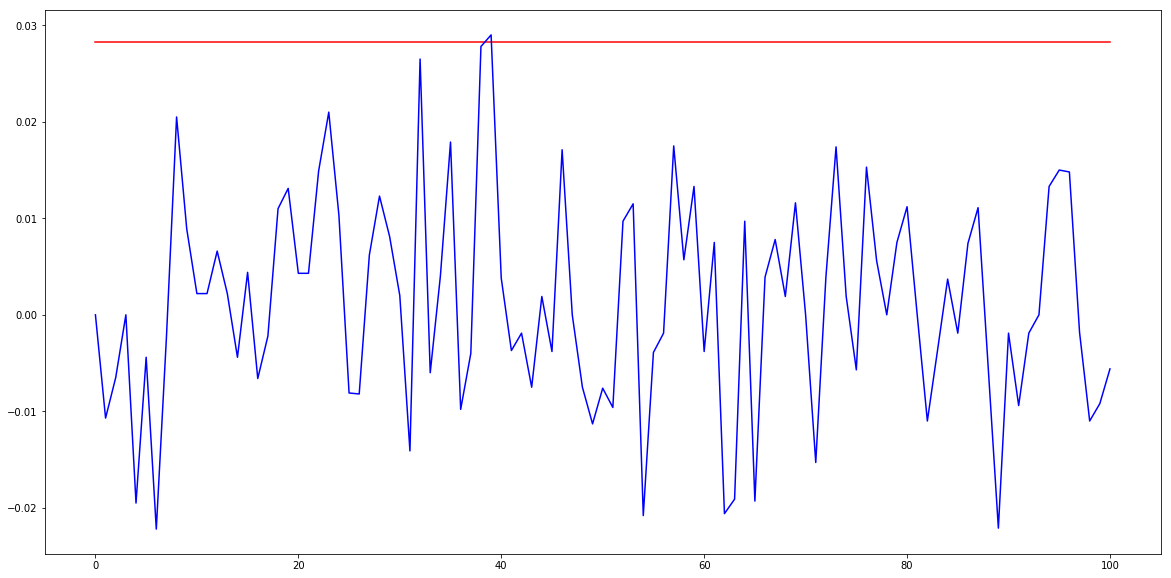

TCAP


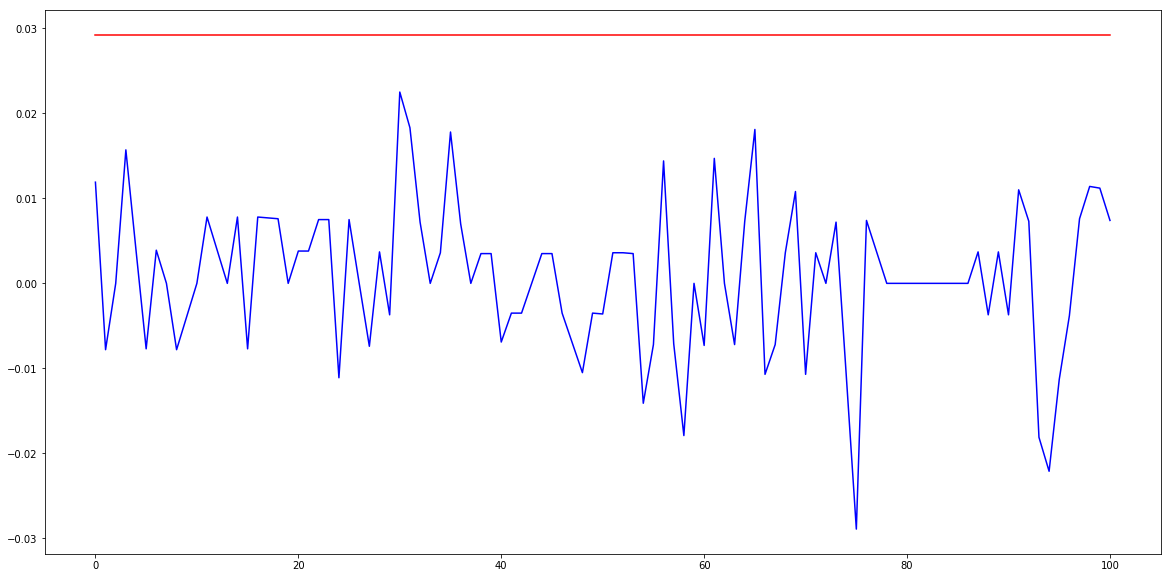

TISCO


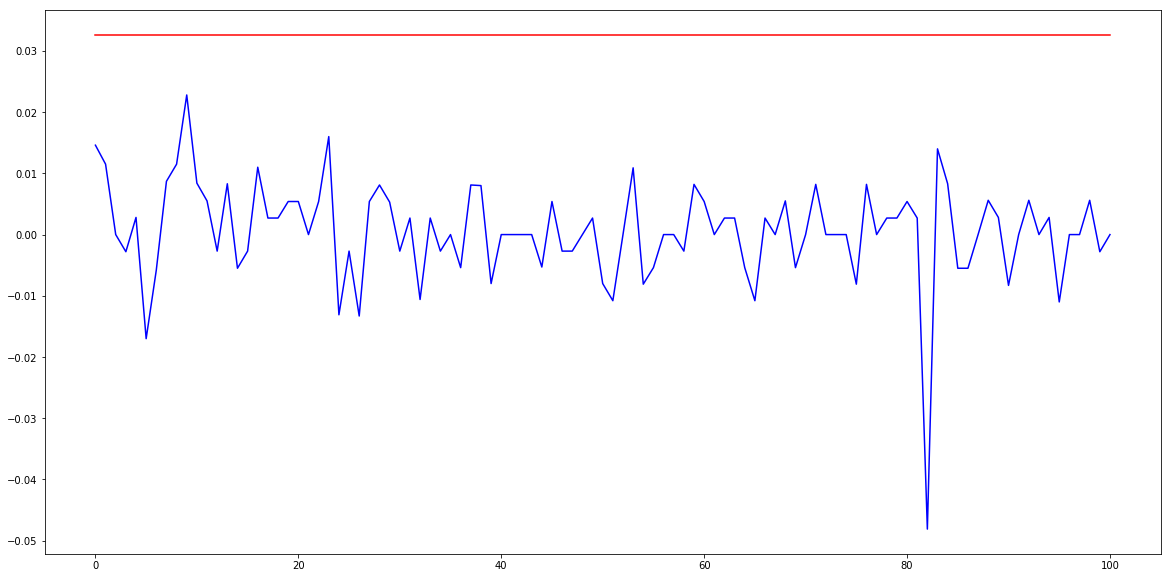

TMB


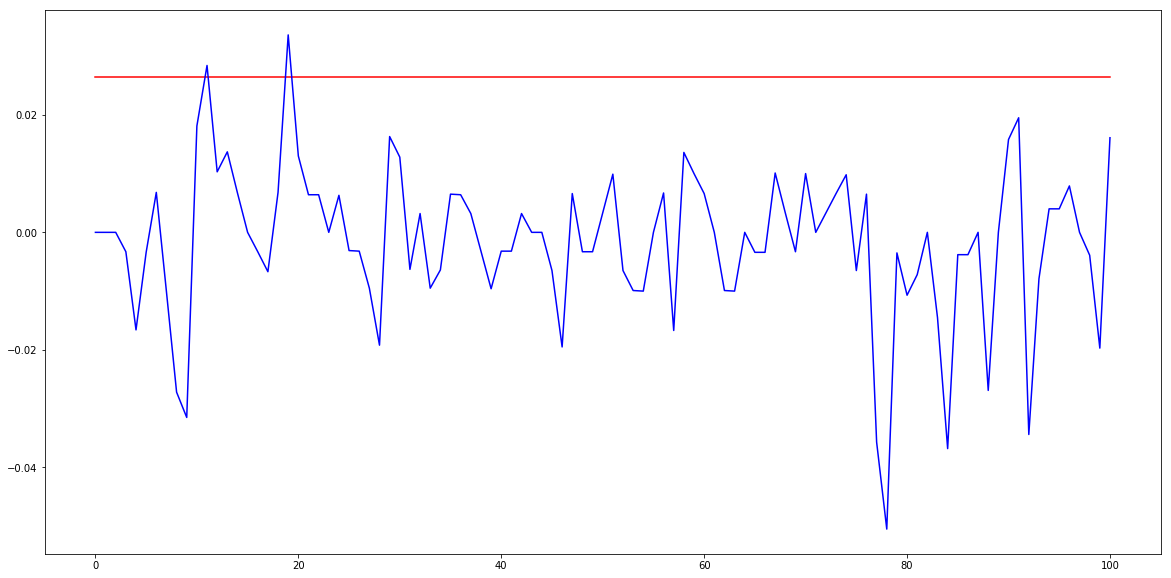

TOP


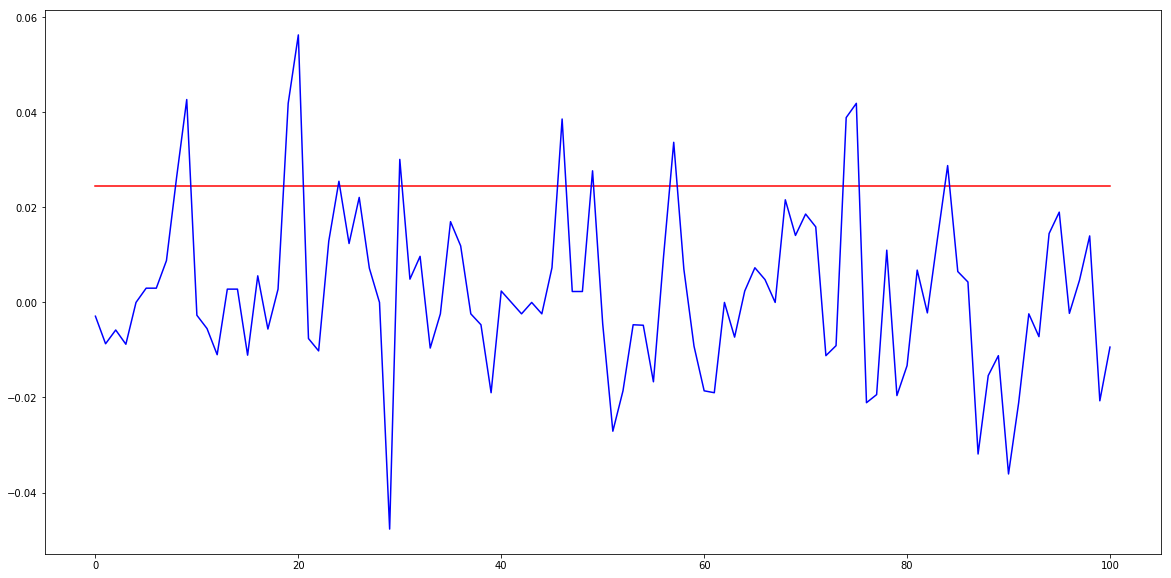

TRUE


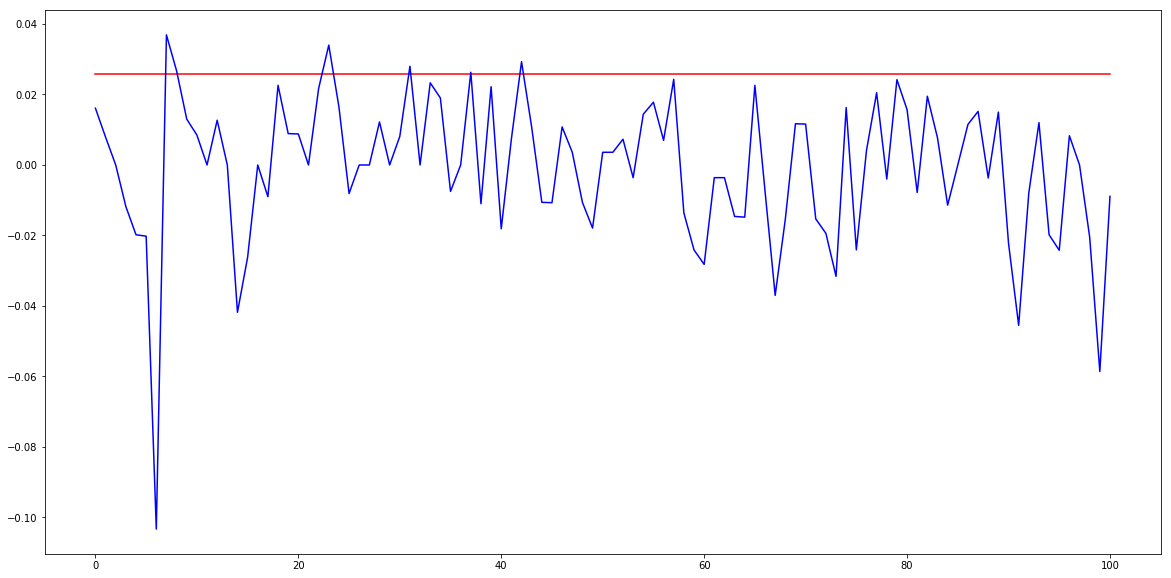

TU


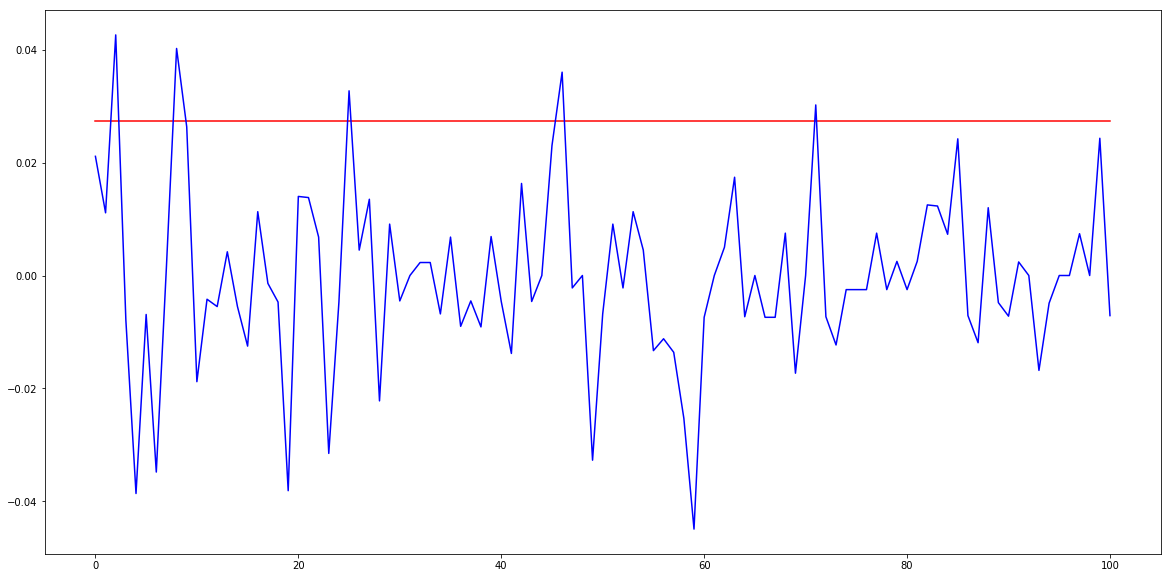

In [234]:
for i in range(len(SET50)):
    print(SET50[i])
    data1 = get_data_from_nparray(predict_adam, i)
    data2 = get_data_from_nparray(y_test, i)
    plot_graph(data1, data2)